# Report mAIstro

A simple agent for report generation based upon a user-supplied schema.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

We'll use the web for research, but this could be easily customized (e.g., to use RAG, etc).

We'll use the [Tavily](https://tavily.com/) web search tool.

In [ ]:
_set_env("TAVILY_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [8]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "report-mAIstro"

## User inputs

Example user inputs: 

* Overall topic 
* Report schema, which can be a JSON object or simply a string description of the report organization

In [67]:
# Report topic 
topic = "Overview of AI Agent Frameworks."

# Test JSON schema input
report_structure_test_1 = {
  "report_sections": [
    {
      "name": "Executive Summary",
      "description": "A concise overview of the entire report's key findings and recommendations.",
    },
    {
      "name": "LangGraph Overview",
      "description": "Review of LangGraph as an agent framework. List the primary goals of the framework and provide a comprehensive summary of its key capabilities, features, and use cases."
    },
    {
      "name": "CrewAI",
      "description": "Review of CrewAI as an agent framework. List the primary goals of the framework and provide a comprehensive summary of its key capabilities, features, and use cases."
    },
    {
      "name": "OpenAI Swarm",
      "description": "Review of OpenAI Swarm as an agent framework. List the primary goals of the framework and provide a comprehensive summary of its key capabilities, features, and use cases."
    },
    {
      "name": "Summary",
      "description": "Summary of agent frameworks with comparative table of features."
    }
  ]
}

# Test natural language input
report_structure_test_2 = "Include sections on the following topics: LangGraph, CrewAI, OpenAI Swarm. In each section, simply list the goal of the framework and a summary of the framework's capabilities. Include an introduction and a concluding summary that contains a comparative table of features."

## Schemas

In [107]:
import operator
from typing_extensions import TypedDict
from typing import  Annotated, List
from pydantic import BaseModel, Field

class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Goals for this section of the report.",
    )
    plan: str = Field(
        description="Organization for this section of the report, if supplied by the user, otherwise provide a reasonable and simple outline."
    )
    research: bool = Field(
        description="Whether to perform web research for this section of the report."
    )
    content: str = Field(
        description="The content of the section."
    )   

class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query for web search.")

class Queries(BaseModel):
    queries: List[SearchQuery] = Field(
        description="List of search queries.",
    )

class ReportState(TypedDict):
    topic: str # Report topic
    report_structure: str # Report structure
    number_of_queries: int # Number web search queries to perform per section    
    sections: list[Section] # List of report sections 
    completed_sections: Annotated[list, operator.add] # Send() API key
    final_report: str # Final report

class SectionState(TypedDict):
    number_of_queries: int # Number web search queries to perform per section 
    section: Section # Report section   
    search_queries: list[SearchQuery] # List of search queries
    source_str: str # String of formatted source content from web search
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API

class SectionOutputState(TypedDict):
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API

## Research plan generation

Look at the input schema, create a research plan for each section of the report based upon it.

Some sections (e.g., introduction and conclusion) may not require web research, as they will summarize or distill information from other sections.

In [63]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# Prompt for research planning with an outline for each section of the report
report_planner_instructions="""Your goal is to generate an outline for a report on: 

{topic}

The report should follow the organization here: 

{report_organization}

Based upon the above report topic and the organization, for each section populate:

* name - Name for this section of the report
* description - Goals for this section of the report
* plan - Organization for this section of the report, if supplied by the user, otherwise provide a reasonable and simple outline.
* research - Whether to perform web research for this section of the report.
* content - The content of the section, which you will leave blank for now.

Consider which sections require web research. 

For example, introduction and conclusion will not require research because they will distill information from other parts of the report."""

def generate_report_plan(state: ReportState):

    # Inputs
    topic = state["topic"]
    report_structure = state["report_structure"]

    # Convert JSON object to string if necessary
    if isinstance(report_structure, dict):
        report_structure = str(report_structure)

    # Format system instructions
    system_instructions = report_planner_instructions.format(topic=topic, report_organization=report_structure)

    # Generate question 
    structured_llm = llm.with_structured_output(Sections)
    report_sections = structured_llm.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate an outline for each section of the report.")])

    return {"sections": report_sections.sections}


In [68]:
# Test with JSON input
sections = generate_report_plan({"topic": topic, "report_structure": report_structure_test_1})
sections

{'sections': [Section(name='Executive Summary', description="A concise overview of the entire report's key findings and recommendations.", plan='1. Introduction to AI Agent Frameworks\n2. Key Findings from the Analysis of LangGraph, CrewAI, and OpenAI Swarm\n3. Recommendations for Selecting an AI Agent Framework\n4. Conclusion', research=False, content=''),
  Section(name='LangGraph Overview', description='Review of LangGraph as an agent framework. List the primary goals of the framework and provide a comprehensive summary of its key capabilities, features, and use cases.', plan='1. Introduction to LangGraph\n2. Primary Goals of LangGraph\n3. Key Capabilities and Features\n4. Use Cases and Applications\n5. Conclusion', research=True, content=''),
  Section(name='CrewAI', description='Review of CrewAI as an agent framework. List the primary goals of the framework and provide a comprehensive summary of its key capabilities, features, and use cases.', plan='1. Introduction to CrewAI\n2. P

In [66]:
# Test with natural language input
sections = generate_report_plan({"topic": topic, "report_structure": report_structure_test_2})
sections


{'sections': [Section(name='Introduction', description='Provide an overview of AI agent frameworks and set the context for the report.', plan='1. Define AI agent frameworks.\n2. Explain the importance of AI agent frameworks in modern technology.\n3. Briefly introduce the frameworks to be discussed: LangGraph, CrewAI, OpenAI Swarm.', research=False, content=''),
  Section(name='LangGraph', description='Discuss the goals and capabilities of the LangGraph framework.', plan='1. State the goal of LangGraph.\n2. Summarize the capabilities of LangGraph.\n3. Highlight any unique features or advantages.', research=True, content=''),
  Section(name='CrewAI', description='Discuss the goals and capabilities of the CrewAI framework.', plan='1. State the goal of CrewAI.\n2. Summarize the capabilities of CrewAI.\n3. Highlight any unique features or advantages.', research=True, content=''),
  Section(name='OpenAI Swarm', description='Discuss the goals and capabilities of the OpenAI Swarm framework.', 

## Web search and section writing

Perform research based upon the plan for each section of the report. 

In [103]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

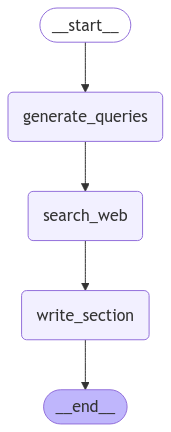

In [108]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# Query writer instructions
query_writer_instructions="""Your goal is to generate queries for a web search.

Here is your topic: 

{section_topic}

Here is the organization of a report section on the topic: 

{section_plan}

Generate the following number of queries that capture unique and non-redundant information from the topic:

{number_of_queries}."""

# Section writer instructions
section_writer_instructions = """You are an expert technical writer. 
            
You are writing one section of a larger report based on a set of source documents about this overall topic: 
{section_topic}

1. Analyze the content of the source documents: 
- Each source document has content and url 
        
2. Create a report structure using markdown formatting:
- Use ## for the title
- Use ### for any sub-sections
- Use ### for the final section focused on sources
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the section, shown here:
{section_title}

5. Create compelling titles for sub-sections based on the outline here:
{section_plan}

6. Use this sources to fill in the details of the sub-sections: 
{context}

7. Final review:
- Ensure the report follows the sub-section structure
- Include no preamble before the title of the report
- Ensure that the section ends with sources"""

def deduplicate_and_format_sources(sources_list):
    """
    Takes a list or list of lists containing source dictionaries and returns
    a single list with unique elements based on URL.
    
    Args:
        sources_list: List or list of lists containing dictionaries with 'url' and 'content' keys
        
    Returns:
        List of unique source dictionaries, formatted string of sources 
    """
    # Flatten the list if it's a list of lists
    flat_list = []
    if isinstance(sources_list[0], list):
        for sublist in sources_list:
            flat_list.extend(sublist)
    else:
        flat_list = sources_list
    
    # Use a dictionary to keep track of unique URLs
    unique_sources = {}
    for source in flat_list:
        if source['url'] not in unique_sources:
            unique_sources[source['url']] = source
    
    # Convert back to list
    sources_list = list(unique_sources.values())
    
    # Format
    formatted_text = "Sources:\n\n"
    for i, source in enumerate(sources_list, 1):
        formatted_text += f"Source {i}:\n"
        formatted_text += f"URL: {source['url']}\n"
        formatted_text += f"Content: {source['content']}\n\n"
    
    return formatted_text.strip()

def generate_queries(state: SectionState):
    """ Generate search queries for a section """

    # Get state 
    number_of_queries = state["number_of_queries"]
    section = state["section"]

    # Generate queries 
    structured_llm = llm.with_structured_output(Queries)

    # Format system instructions
    system_instructions = query_writer_instructions.format(section_topic=section.description, section_plan=section.plan, number_of_queries=number_of_queries)

    # Generate queries  
    queries = structured_llm.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate search queries on the provided topic.")])

    return {"search_queries": queries.queries}

def search_web(state: SectionState):
    """ Search the web for each query, then return a list of raw sources and a formatted string of sources."""
    
    # Get state 
    search_queries = state["search_queries"]

    # Search web 
    search_docs = tavily_search.batch([q.search_query for q in search_queries])

    # Deduplicate and format sources
    source_str = deduplicate_and_format_sources(search_docs)

    return {"source_str": source_str}

def write_section(state: SectionState):
    """ Write a section of the report """

    # Get state 
    section = state["section"]
    source_str = state["source_str"]

    # Format system instructions
    system_instructions = section_writer_instructions.format(section_title=section.name, section_topic=section.description, section_plan=section.plan, context=source_str)

    # Generate section  
    section_content = llm.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate a report section based on the provided sources.")])
    
    # Write content to the section object  
    section.content = section_content.content

    # Write the updated section to completed sections
    return {"completed_sections": [section]}

# Add nodes and edges 
section_builder = StateGraph(SectionState, output=SectionOutputState)
section_builder.add_node("generate_queries", generate_queries)
section_builder.add_node("search_web", search_web)
section_builder.add_node("write_section", write_section)

section_builder.add_edge(START, "generate_queries")
section_builder.add_edge("generate_queries", "search_web")
section_builder.add_edge("search_web", "write_section")
section_builder.add_edge("write_section", END)

# Compile
section_builder_graph = section_builder.compile()

# View
display(Image(section_builder_graph.get_graph(xray=1).draw_mermaid_png()))


In [99]:
sections['sections']

[Section(name='Executive Summary', description="A concise overview of the entire report's key findings and recommendations.", plan='1. Introduction to AI Agent Frameworks\n2. Key Findings from the Analysis of LangGraph, CrewAI, and OpenAI Swarm\n3. Recommendations for Selecting an AI Agent Framework\n4. Conclusion', research=False, content=''),
 Section(name='LangGraph Overview', description='Review of LangGraph as an agent framework. List the primary goals of the framework and provide a comprehensive summary of its key capabilities, features, and use cases.', plan='1. Introduction to LangGraph\n2. Primary Goals of LangGraph\n3. Key Capabilities and Features\n4. Use Cases and Applications\n5. Conclusion', research=True, content=''),
 Section(name='CrewAI', description='Review of CrewAI as an agent framework. List the primary goals of the framework and provide a comprehensive summary of its key capabilities, features, and use cases.', plan='1. Introduction to CrewAI\n2. Primary Goals of

In [100]:
sections['sections'][0]

Section(name='Executive Summary', description="A concise overview of the entire report's key findings and recommendations.", plan='1. Introduction to AI Agent Frameworks\n2. Key Findings from the Analysis of LangGraph, CrewAI, and OpenAI Swarm\n3. Recommendations for Selecting an AI Agent Framework\n4. Conclusion', research=False, content='')

In [101]:
completed_section = section_builder_graph.invoke({"section": sections['sections'][0], "number_of_queries": 2})
completed_section


{'number_of_queries': 2,
 'section': Section(name='Executive Summary', description="A concise overview of the entire report's key findings and recommendations.", plan='1. Introduction to AI Agent Frameworks\n2. Key Findings from the Analysis of LangGraph, CrewAI, and OpenAI Swarm\n3. Recommendations for Selecting an AI Agent Framework\n4. Conclusion', research=False, content="## Executive Summary\n\n### Introduction to AI Agent Frameworks\n\nAI agent frameworks are powerful tools that enable developers to build smart, independent systems capable of making decisions and carrying out tasks autonomously. These frameworks are transforming the development of intelligent systems, from simple chatbots to complex autonomous systems. The interplay between decision-making models, communication protocols, and task management utilities shapes an AI agent’s capabilities and performance. The world of AI agent frameworks is buzzing with innovation, offering developers a range of options to bring thei

## Write sections


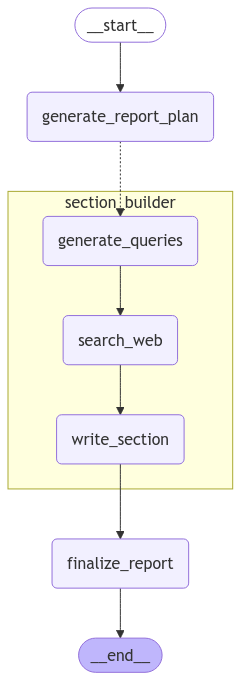

In [109]:
from langgraph.constants import Send

def initiate_section_writing(state: ReportState):
    """ This is the "map" step when we kick off research on any sections that require it using the Send API """    

    # State
    number_of_queries = state["number_of_queries"]
    
    # Kick off section writing in parallel via Send() API for any sections that require research
    return [
        Send("section_builder", {"section": s, "number_of_queries": state["number_of_queries"]}) 
        for s in state["sections"] 
        if s.research
    ]

def format_sections(sections: list[Section]) -> str:
    """ Format a list of sections into a string """
    formatted_str = ""
    for idx, section in enumerate(sections, 1):
        formatted_str += f"""
{'='*60}
Section {idx}: {section.name}
{'='*60}
Description:
{section.description}

Plan:
{section.plan}

Requires Research: {section.research}

Content:
{section.content if section.content else '[Not yet written]'}

"""
    return formatted_str

final_section_writer_instructions="""You are an expert technical writer. 
            
You are writing one section of a larger report. Here is the section topic: 
{section_topic}

1. Analyze the content of the source documents: 
- Each source document has content and url 
        
2. Create a report structure using markdown formatting:
- Use ## for the title
- Use ### for any sub-sections

3. Make your title engaging based upon the focus area of the section, shown here:
{section_title}

4. Create compelling titles for sub-sections based on the outline here:
{section_plan}

5. Here is content from the rest of the report to guide your section: 
{context}

6. Final review:
- Ensure the section follows the sub-section structure
- Include no preamble before the title of the report"""

def finalize_report(state: ReportState):
    """ Write any final sections based the the rest of the report and compile the final report """    

    # Get sections
    sections = state["sections"]
    completed_sections = state["completed_sections"]

    # Update master list with completed content from web research
    for completed in completed_sections:
        for section in sections:
            if section.name == completed.name:
                section.content = completed.content

    # Format completed section to str in order to write the final sections
    formatted_report_sections = format_sections(completed_sections)

    # Write final sections that did not require web research
    for section in sections:

        # Section did not require web research
        if not section.research:

            # Format system instructions
            system_instructions = final_section_writer_instructions.format(section_title=section.name, section_topic=section.description, section_plan=section.plan, context=formatted_report_sections)

            # Generate section  
            section_content = llm.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate a report section based on the provided sources.")])
        
            # Write content to section 
            section.content = section_content.content

    # Compile final report
    all_sections = "\n\n".join([s.content for s in sections])

    return {"sections": sections, "final_report": all_sections}

# Add nodes and edges 
builder = StateGraph(ReportState)
builder.add_node("generate_report_plan", generate_report_plan)
builder.add_node("section_builder", section_builder.compile())
builder.add_node("finalize_report", finalize_report)
builder.add_edge(START, "generate_report_plan")
builder.add_conditional_edges("generate_report_plan", initiate_section_writing, ["section_builder"])
builder.add_edge("section_builder", "finalize_report")
builder.add_edge("finalize_report", END)

graph = builder.compile()
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [110]:
final_state = graph.invoke({"topic": topic, "report_structure": report_structure_test_2, "number_of_queries": 2})

In [111]:
from IPython.display import Markdown
Markdown(final_state['final_report'])

## Introduction to AI Agent Frameworks: Pioneering the Future of Artificial Intelligence

### Defining AI Agent Frameworks
AI agent frameworks are structured environments or platforms designed to facilitate the development, coordination, and execution of artificial intelligence agents. These frameworks provide the necessary tools and infrastructure to create, manage, and deploy AI agents that can perform specific tasks autonomously or collaboratively. By offering a standardized approach to building AI systems, these frameworks enable developers to focus on designing intelligent behaviors and interactions, rather than dealing with the complexities of underlying infrastructure.

### The Importance of AI Agent Frameworks in AI Development
AI agent frameworks play a crucial role in the advancement of artificial intelligence by streamlining the development process and enhancing the capabilities of AI systems. They allow for the efficient orchestration of multiple agents, enabling complex problem-solving and decision-making processes that would be challenging to achieve with isolated agents. These frameworks also promote scalability, flexibility, and collaboration, which are essential for tackling real-world applications across various industries. By providing a robust foundation for AI development, agent frameworks accelerate innovation and deployment, ultimately driving the evolution of AI technologies.

### Introducing the Frameworks: LangGraph, CrewAI, OpenAI Swarm
In this report, we will explore three prominent AI agent frameworks: LangGraph, CrewAI, and OpenAI Swarm. Each of these frameworks offers unique features and capabilities that contribute to the field of artificial intelligence in distinct ways. LangGraph focuses on the orchestration of language model agents, CrewAI emphasizes collaborative intelligence among role-playing agents, and OpenAI Swarm revolutionizes multi-agent systems with its adaptable and scalable platform. Through an in-depth analysis of these frameworks, we aim to highlight their significance and potential impact on the future of AI development.

## LangGraph: Unleashing the Power of AI Agents

### Defining the Goal of LangGraph
LangGraph is a framework within the LangChain ecosystem designed to streamline the development and execution of AI agents. The primary goal of LangGraph is to provide a structured environment for defining, coordinating, and executing multiple language model (LLM) agents, or chains, in a cohesive manner. By implementing LangGraph, developers can create modular components tailored to specific functionalities, such as natural language understanding and response generation, ensuring that AI agents meet user expectations and objectives (Source 1, Source 2).

### Exploring the Capabilities of LangGraph
LangGraph offers a robust framework that supports diverse control flows, including single-agent, multi-agent, hierarchical, and sequential configurations. It simplifies the development process by enabling the creation of cyclical graphs, which are crucial for orchestrating the interactions of multiple LLM agents. This capability ensures smooth communication and efficient execution of complex tasks, allowing developers to build systems that can handle realistic scenarios with ease (Source 2, Source 3, Source 5).

### Unique Features and Advantages of LangGraph
One of the standout features of LangGraph is its flexibility and extensive customization options. It allows developers to represent workflows as cyclical graphs, facilitating the orchestration of multiple agents and ensuring efficient task execution. LangGraph also supports the integration of external tools and APIs, enabling sophisticated state management and the implementation of human-in-the-loop setups. Additionally, the framework includes moderation and quality loops to maintain agent reliability and prevent deviations from intended outcomes (Source 3, Source 4, Source 5).

### Sources
- [AI Agents in LangGraph](https://www.rapidinnovation.io/post/ai-agents-in-langgraph)
- [LangGraph Tutorial](https://www.datacamp.com/tutorial/langgraph-tutorial)
- [LangGraph Tutorial for Beginners](https://blog.futuresmart.ai/langgraph-tutorial-for-beginners)
- [Exploring LangGraph](https://towardsdatascience.com/from-basics-to-advanced-exploring-langgraph-e8c1cf4db787)
- [LangGraph Platform](https://www.langchain.com/langgraph)

## Unleashing the Power of CrewAI: A Revolutionary Framework for AI Collaboration

### Defining the Ambitious Goal of CrewAI
CrewAI is a groundbreaking open-source framework designed to orchestrate role-playing AI agents, enabling them to work cohesively towards shared objectives. The primary goal of CrewAI is to facilitate the collaboration of autonomous AI agents, each assigned specific roles and responsibilities, to enhance the efficiency and effectiveness of AI-driven processes. By redefining AI collaboration through its innovative approach to multi-agent orchestration, CrewAI empowers autonomous AI agents to tackle complex tasks, thereby enhancing decision-making capabilities and streamlining workflows across various industries.

### Exploring the Capabilities of CrewAI
CrewAI operates by orchestrating multiple AI agents through a structured process, which has transformative implications across various sectors. It enables developers to build and deploy automated workflows using multiple AI agents that collaborate to perform complex tasks. The framework supports the development and management of multi-agent AI systems, making it perfect for both basic and complex applications. CrewAI's design and scalability encourage a collaborative method for tackling challenges and making decisions within AI systems, ultimately reducing costs and improving operational efficiency.

### Unique Features and Advantages of CrewAI
One of the unique features of CrewAI is its introduction of the concept of "crews," where a team of agents, each with a well-defined role, goal, and backstory, work together seamlessly. This approach elevates the concept of agentic frameworks, fostering collaborative intelligence among agents. Although CrewAI operates as a black box, meaning there is limited control over the process, it significantly reduces human effort by automatically choosing tools. This capability allows for real-time collaboration and enhances the overall effectiveness of AI-driven processes.

### Sources
- [CrewAI Guide](https://insights.codegpt.co/crewai-guide)
- [A Complete Guide to CrewAI and Agentic Frameworks](https://medium.com/@harshav.vanukuri/a-complete-guide-to-crew-ai-and-agentic-frameworks-unleashing-the-power-of-autonomous-ai-crews-9911f39110f5)
- [CrewAI: A Framework for Building Agents](https://medium.com/@speaktoharisudhan/crewai-a-framework-for-building-agents-170ccf929b3c)
- [CrewAI GitHub Repository](https://github.com/supamakers/crewai)
- [DataCamp Tutorial on CrewAI](https://www.datacamp.com/tutorial/crew-ai)

## OpenAI Swarm: Revolutionizing Multi-Agent AI Systems

### The Goal of OpenAI Swarm
OpenAI Swarm is an experimental AI framework developed by OpenAI with the primary goal of facilitating the development, orchestration, and deployment of multi-agent systems. This framework aims to simplify the process of coordinating multiple AI agents to solve complex tasks by enabling a more collaborative and flexible approach to problem-solving. By streamlining the coordination and execution of multiple AI agents within a single environment, OpenAI Swarm represents a significant step forward in the development of multi-agent AI systems (Source 4).

### Capabilities of OpenAI Swarm
OpenAI Swarm empowers developers to build intricate AI applications with unprecedented ease. It allows for the seamless coordination of AI agents, which can be used to create personalized experiences, such as tailored travel itineraries that feel like they come from a team of expert travel agents. The framework supports the integration of real-time APIs, enabling agents to handle tasks like hotel bookings, restaurant reservations, and car rentals efficiently. This capability significantly reduces response times and improves customer satisfaction in various applications, including customer service (Sources 2 and 3).

### Unique Features and Advantages
OpenAI Swarm introduces several key features that distinguish it from other multi-agent orchestration frameworks. Unlike frameworks like AgentSim and MARL systems, which focus on training or specific simulation environments, Swarm offers an adaptable, scalable platform for real-world, decentralized multi-agent coordination. This flexibility and scalability make it a powerful tool for developers looking to implement multi-agent systems in diverse and dynamic environments. The framework's open-source nature also encourages collaboration and innovation within the developer community, further enhancing its potential impact (Source 5).

### Sources
- [GitHub - openai/swarm](https://github.com/openai/swarm)
- [Building Intelligent Multi-Agent Systems with Swarm](https://dzone.com/articles/building-intelligent-multi-agent-systems-with-swarm)
- [OpenAI Swarm Guide](https://insights.codegpt.co/openai-swarm-guide)
- [OpenAI Releases Swarm: An Experimental AI Framework for Multi-Agent Systems](https://medium.com/cool-devs/openai-releases-swarm-an-experimental-ai-framework-for-multi-agent-systems-2e2d9372f839)
- [A Deep Dive into OpenAI’s Swarm Framework: The Future of Multi-Agent AI Systems](https://medium.com/@hybrid.minds/a-deep-dive-into-openais-swarm-framework-the-future-of-multi-agent-ai-systems-c00e395be1b3)

## Conclusion: Charting the Future of AI Agent Frameworks

### Recapping the Goals and Capabilities of Each Framework

In this report, we explored three innovative AI frameworks: LangGraph, CrewAI, and OpenAI Swarm, each with distinct goals and capabilities.

- **LangGraph** aims to streamline the development and execution of AI agents by providing a structured environment for coordinating multiple language model agents. Its capabilities include supporting diverse control flows and enabling the creation of cyclical graphs for efficient task execution.

- **CrewAI** focuses on orchestrating role-playing AI agents to work cohesively towards shared objectives. It facilitates collaboration among autonomous agents, enhancing decision-making and streamlining workflows through its unique "crews" concept.

- **OpenAI Swarm** is designed to simplify the coordination of multi-agent systems, enabling collaborative problem-solving. It supports real-time API integration and offers a scalable platform for decentralized multi-agent coordination.

### Comparative Table of Features

| Feature/Framework | LangGraph | CrewAI | OpenAI Swarm |
|-------------------|-----------|--------|--------------|
| **Primary Goal** | Streamline AI agent development | Facilitate AI agent collaboration | Simplify multi-agent coordination |
| **Control Flow** | Single, multi-agent, hierarchical, sequential | Role-based agent collaboration | Decentralized multi-agent coordination |
| **Unique Concept** | Cyclical graphs for task orchestration | "Crews" of role-playing agents | Real-time API integration |
| **Customization** | Extensive options for workflows | Limited control, automatic tool selection | Open-source, adaptable platform |
| **Integration** | External tools and APIs | Automated workflow deployment | Real-time APIs for dynamic tasks |

### Insights on the Future of AI Agent Frameworks

The future of AI agent frameworks is poised for significant advancements, driven by the unique capabilities and goals of LangGraph, CrewAI, and OpenAI Swarm. As these frameworks continue to evolve, they will likely foster more sophisticated AI systems capable of handling complex, real-world scenarios with greater efficiency and collaboration. The integration of real-time data and the ability to seamlessly coordinate multiple agents will be crucial in enhancing the effectiveness of AI-driven processes across various industries. As open-source platforms like OpenAI Swarm encourage community collaboration, we can anticipate a surge in innovation and the development of more versatile and powerful AI frameworks.